In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
matplotlib.style.use('seaborn-v0_8')
matplotlib.rcParams['figure.figsize'] = (12,6)

notebook_path = os.path.abspath("CPAC.ipynb")
notebook_dir = os.path.dirname(notebook_path)

Load Data

In [3]:
# Subset of Data (1.5GB per set, 10,000 observations) 
Xdata = np.load(notebook_dir+'\\Xdata_MeansGS.npy') # data with the "noise" of the atmosphere
# clean up Xdata if needed
np.nan_to_num(Xdata, copy=False, nan=1)
Xdata[Xdata<1] = 1
Refdata = np.load(notebook_dir+'\\Ydata_MeansGS.npy') # Reflectance
# clean up Refdata if needed
Refdata[Refdata<0] = 0
# Full Data (43GB per set, 300,000 observations)
#Xdata = np.load('Xdata.npy') # data with the "noise" of the atmosphere
#Ydata = np.load('Ydata.npy') # clean material spectra
wl = np.load(notebook_dir+'\\wl.npy')
nObs, nSpec, nBands = Xdata.shape
print("Num Observations: "+str(nObs))
print("Num Spectra per observation: "+str(nSpec))
print("Num Bands: "+str(nBands))
Ydata = Refdata#/Xdata # the gains we want to predict
# remove data for bad/water bands with nans
IdxGood = np.isfinite(Ydata[0,0])
Ydata = Ydata[:,:,IdxGood]
Xdata = Xdata[:,:,IdxGood]
wl = wl[IdxGood]

Num Observations: 10000
Num Spectra per observation: 40
Num Bands: 409


In [4]:
QUAC_mean = np.mean(Ydata[:,39,:], axis=0)
QUAC_mean.shape

(409,)

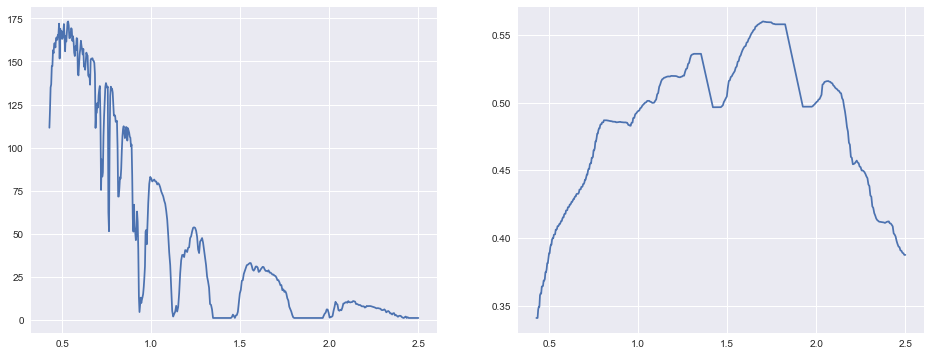

In [26]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(wl,Xdata[0,0,:]);
plt.subplot(122)
plt.plot(wl,Ydata[0,0,:]);

Test / Trin Split

In [27]:
# set aside 1/3 of train and test data for validation
X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Ydata, test_size=0.33, random_state=42)
# Use just the means from the X-data for training and testing, but save the full X-data for future comparison
X_test_full = X_test[:]
X_train = X_train[:,0,:]
X_test = X_test[:,0,:]
Y_test_full = Y_test[:]
Y_train = Y_train[:,0,:]
Y_test = Y_test[:,0,:]
nTrainObs,nBandsY = np.shape(Y_train)
nTestObs,_ = np.shape(Y_test)
print("Bands: "+str(nBandsY))

Bands: 409


Plot some data

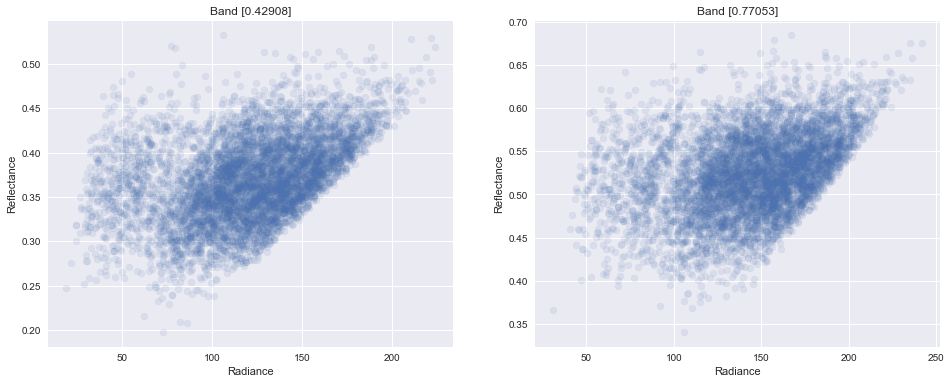

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(121)
nPts = 15000
x = X_train[1:nPts,0]
y = Y_train[1:nPts,0]
plt.scatter(x,y, alpha=0.1)
plt.xlabel('Radiance')
plt.ylabel('Reflectance')
plt.title('Band '+str(wl[0]))
plt.subplot(122)
nPts = 15000
x = X_train[1:nPts,100]
y = Y_train[1:nPts,100]
plt.scatter(x,y, alpha=0.1)
plt.xlabel('Radiance')
plt.ylabel('Reflectance')
plt.title('Band '+str(wl[100]))
plt.savefig('scatterPlotsRadVsRefl.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

In [29]:
np.shape(Y_train)

(6700, 409)

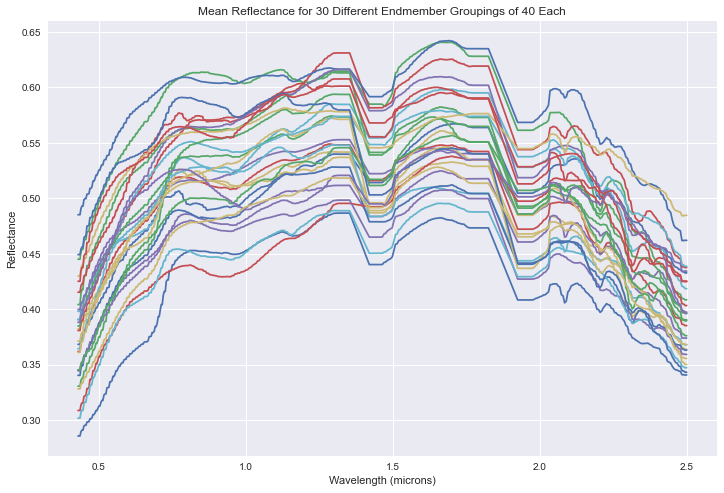

In [30]:
plt.figure(figsize=(12,8))
plt.plot(wl, Y_train[1:30,:].T)
plt.xlabel("Wavelength (microns)")
plt.ylabel("Reflectance")
plt.title('Mean Reflectance for 30 Different Endmember Groupings of 40 Each')
plt.savefig('EndmemberMeans.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

In [31]:
np.shape(X_train)

(6700, 409)

In [32]:
S_test = np.hstack((X_test,Y_test))
S_train = np.hstack((X_train,Y_train))
nRows, nCols = np.shape(S_train)

In [33]:
# Demean the data
m = np.mean(S_train, 0)
for c in range(nCols):
  S_train[:,c] = S_train[:,c] - m[c]

In [34]:
# Compute the covariance
C = np.zeros((nCols,nCols))
for r in range(0,nRows,2):
  if (r%500==0):
    print(r)
  C = C + np.matmul(S_test[r:(r+1),:].T, S_test[r:(r+1),:]) 
C = C/nRows
print(np.shape(C))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
(818, 818)


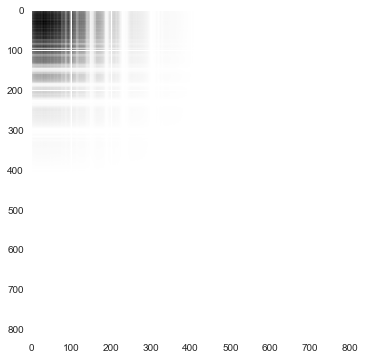

In [35]:
plt.imshow(C)
plt.show()

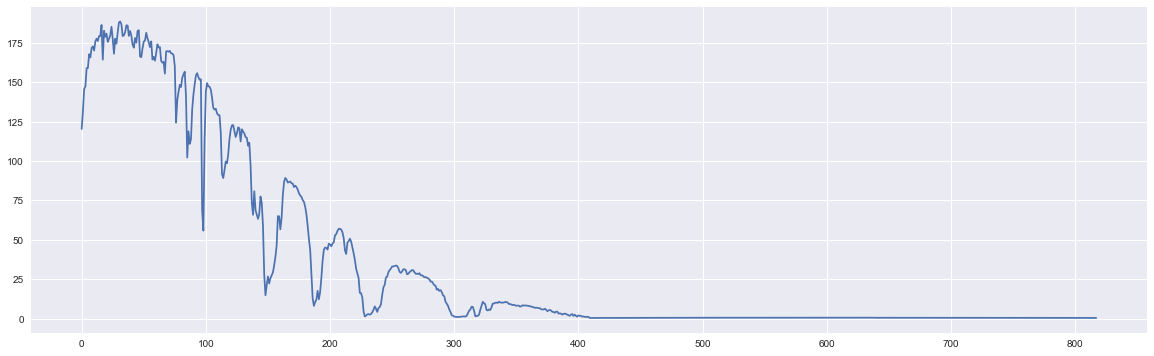

In [36]:
plt.figure(figsize=(20,6))
plt.plot(m);

In [37]:
m_a = m[0:nBandsY]
m_b = m[nBandsY:2*nBandsY]
Caa = C[0:nBandsY,0:nBandsY]
Cab = C[0:nBandsY,nBandsY:2*nBandsY]
Cba = C[nBandsY:2*nBandsY,0:nBandsY]
Cbb = C[nBandsY:2*nBandsY,nBandsY:2*nBandsY]
print(np.shape(m_a))
print(np.shape(m_b))
print(np.shape(Caa))
print(np.shape(Cab))
print(np.shape(Cba))
print(np.shape(Cbb))
CaaInv = np.linalg.inv(Caa)

(409,)
(409,)
(409, 409)
(409, 409)
(409, 409)
(409, 409)


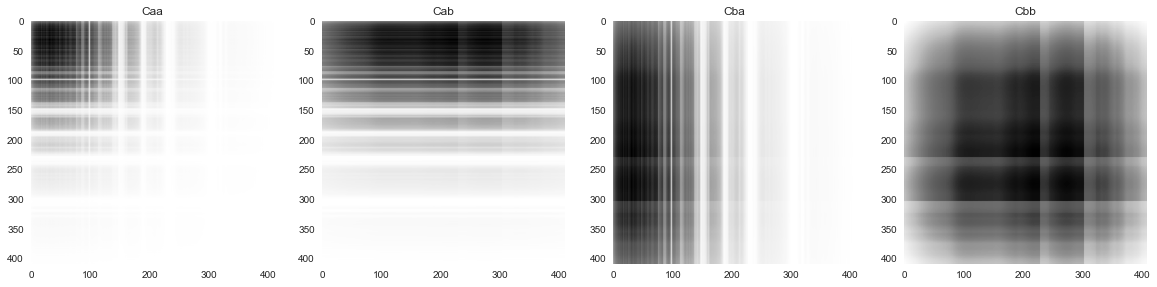

In [38]:
plt.figure(figsize=(20,8))
plt.subplot(141)
plt.imshow(Caa)
plt.grid(None)
plt.title('Caa')
plt.subplot(142)
plt.imshow(Cab)
plt.grid(None) 
plt.title('Cab')
plt.subplot(143)
plt.imshow(Cba)
plt.grid(None) 
plt.title('Cba')
plt.subplot(144)
plt.imshow(Cbb)
plt.grid(None) 
plt.title('Cbb')
plt.savefig('covariance.png', dpi=500, bbox_inches='tight', pad_inches=0.1);
plt.show()

In [39]:
def pred(xa,m_a,m_b,Cba,CaaInv):
  return m_b + np.matmul(np.matmul(Cba,CaaInv),xa-m_a)

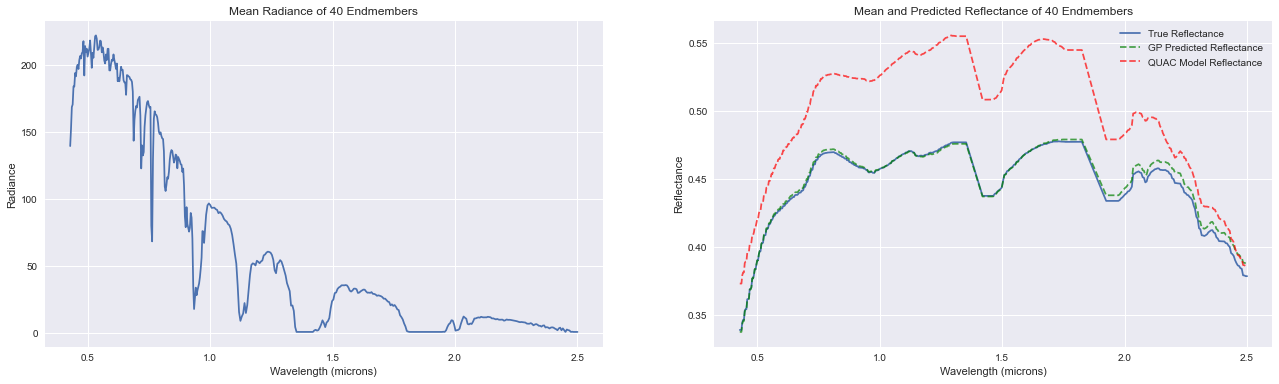

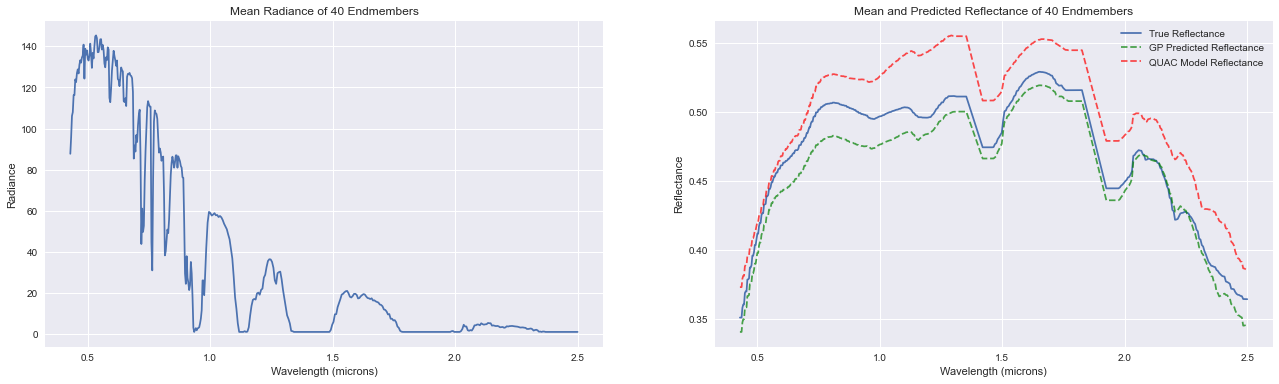

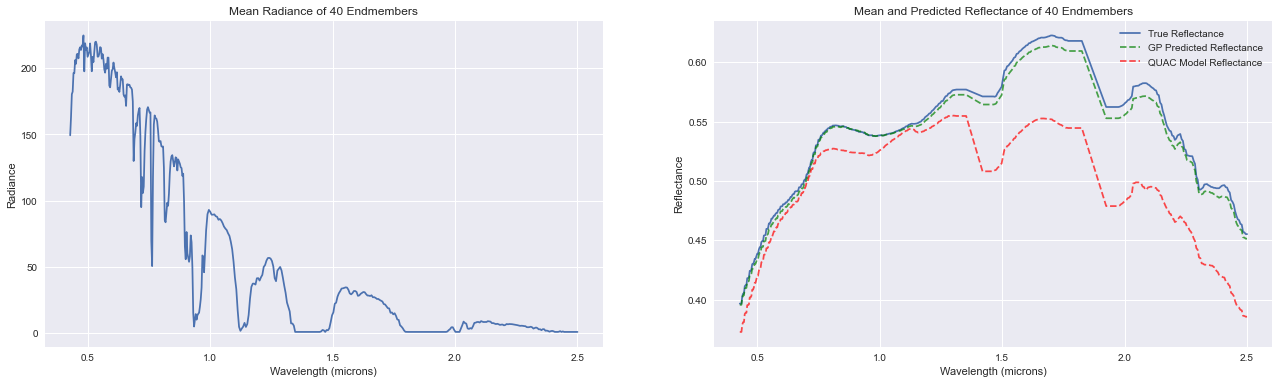

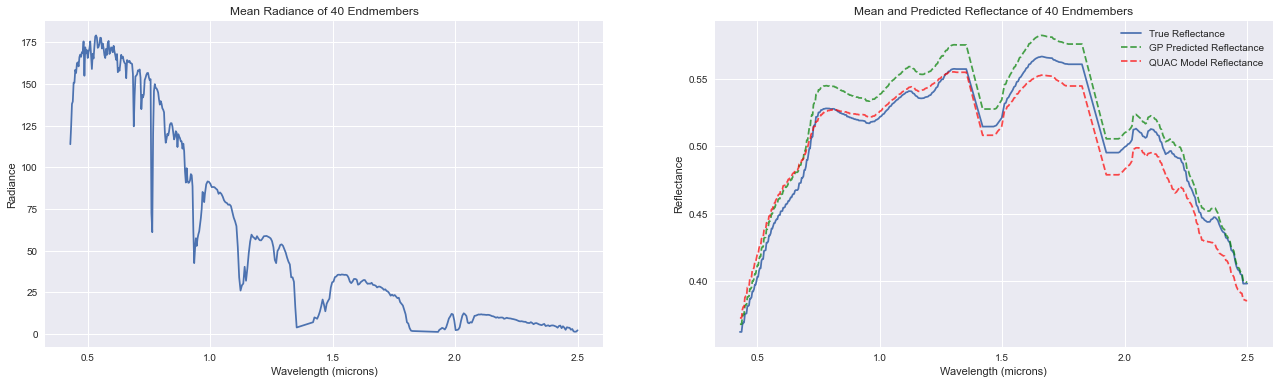

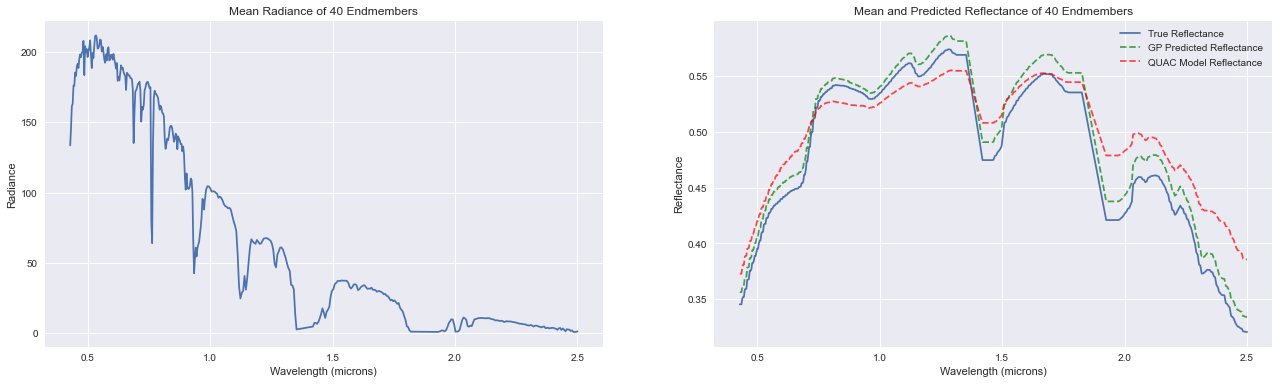

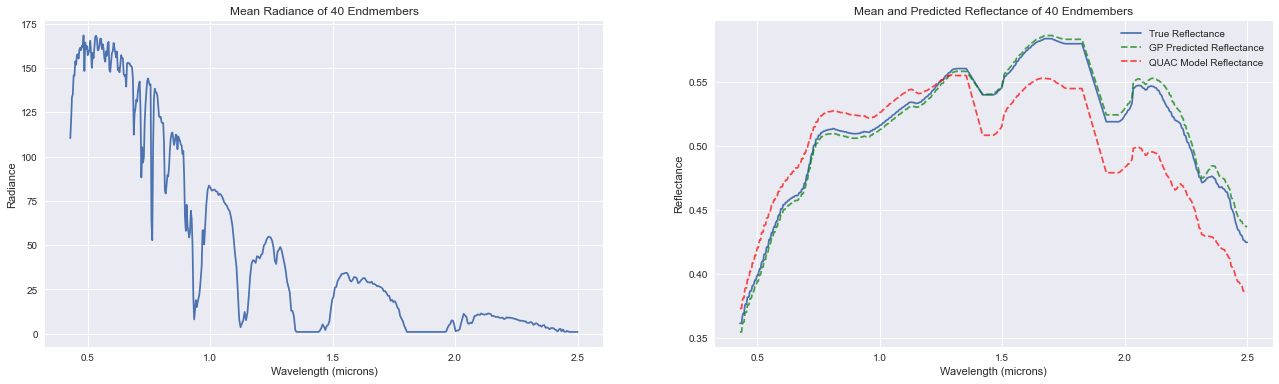

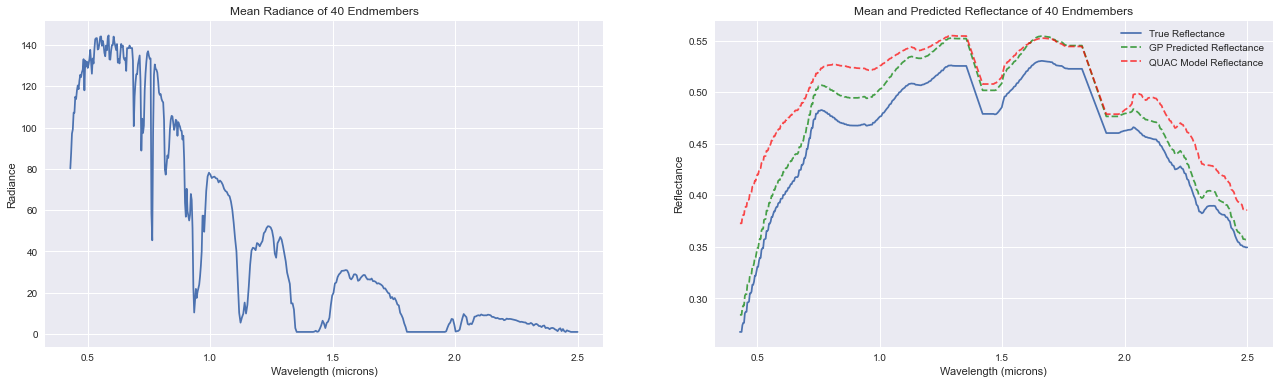

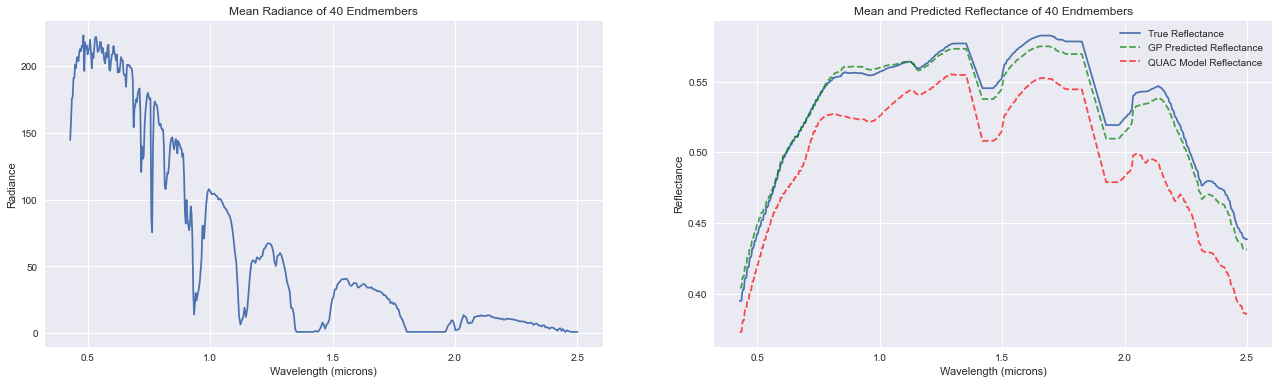

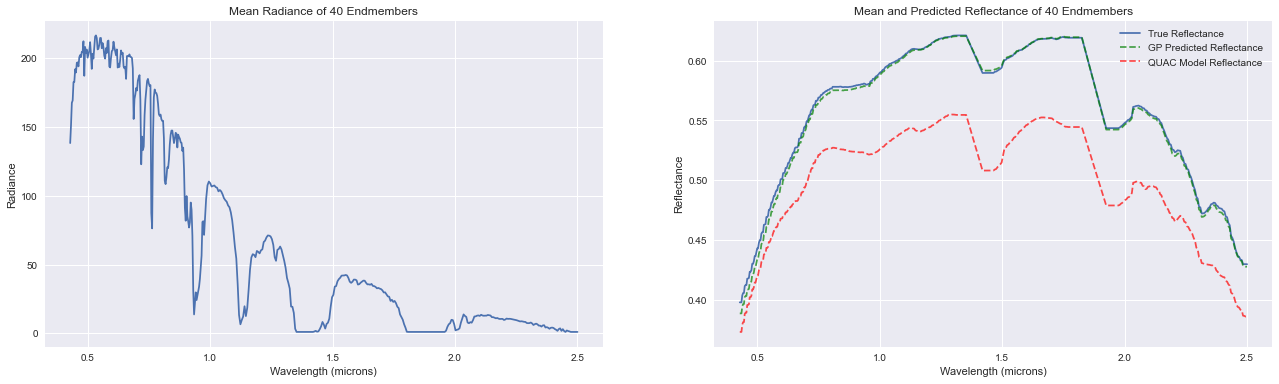

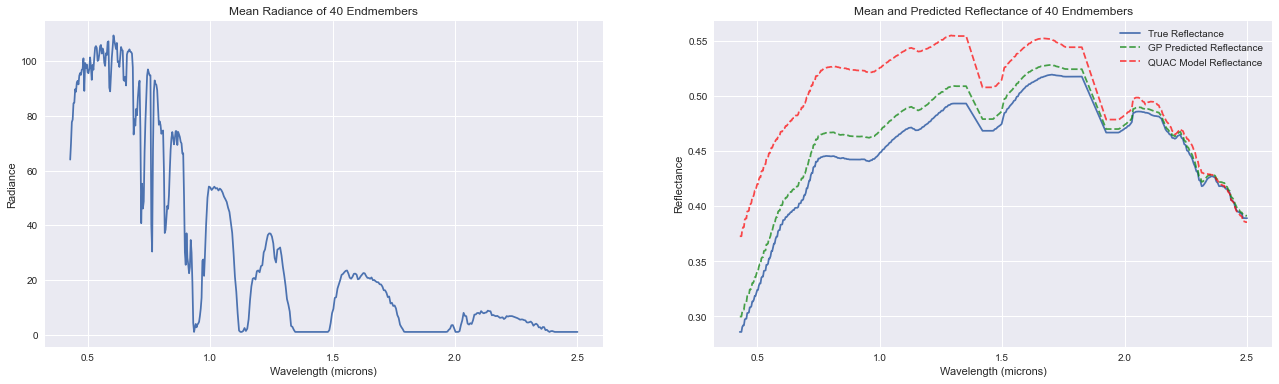

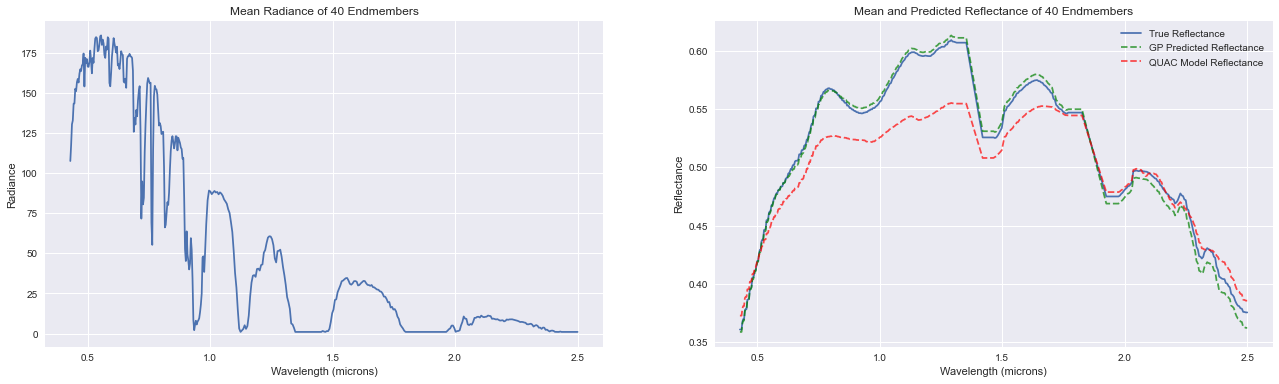

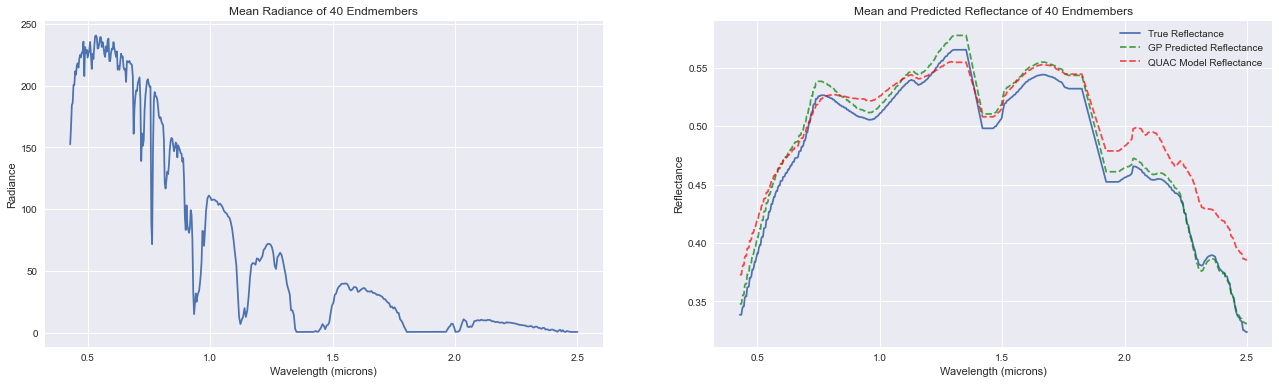

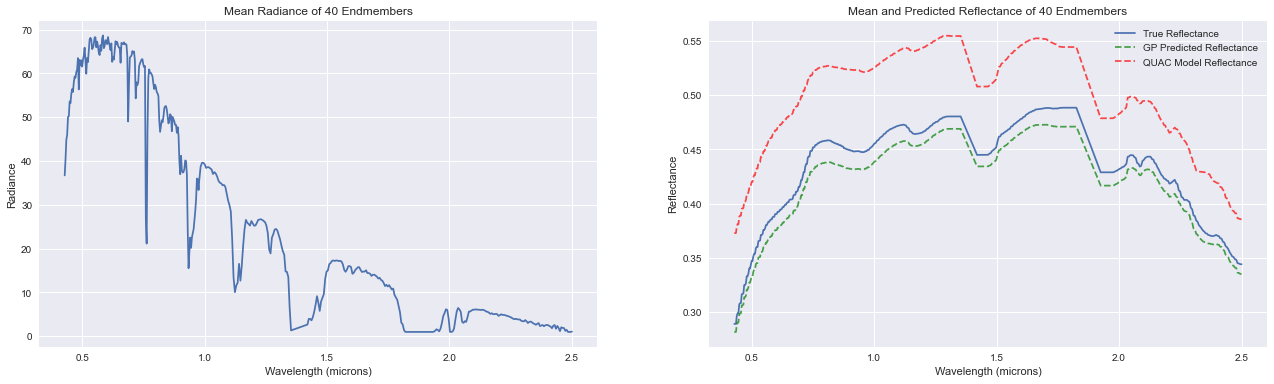

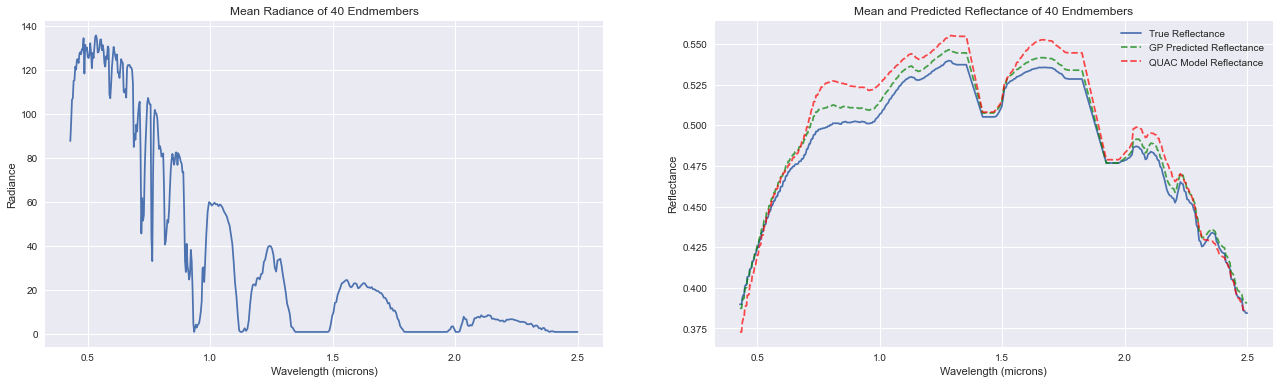

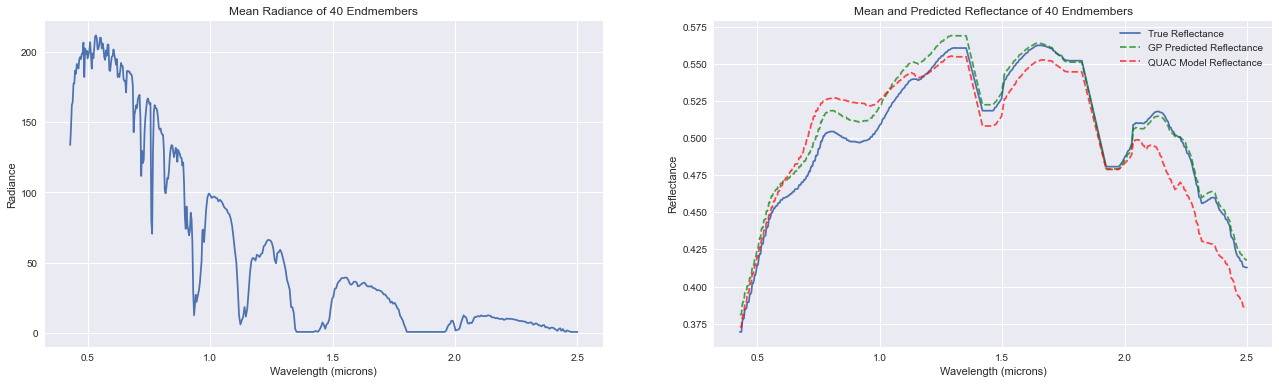

In [46]:
for idx in range(15):
  Y_pred = pred(X_test[idx,:],m_a,m_b,Cba,CaaInv)
  plt.figure(figsize=(22,6))
  plt.subplot(121)
  plt.plot(wl,X_test[idx,:])
  plt.ylabel('Radiance')
  plt.xlabel('Wavelength (microns)')
  plt.title('Mean Radiance of 40 Endmembers')
  plt.subplot(122)
  plt.title('Mean and Predicted Reflectance of 40 Endmembers')
  plt.plot(wl,Y_test[idx,:], label='True Reflectance')
  plt.plot(wl,Y_pred, 'g--', label='GP Predicted Reflectance', alpha=0.7)
  plt.plot(wl,QUAC_mean, 'r--', label='QUAC Model Reflectance', alpha=0.7)
  plt.ylabel('Reflectance')
  plt.xlabel('Wavelength (microns)')
  plt.legend();
  plt.savefig('RadianceAndReflectance'+str(idx)+'.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

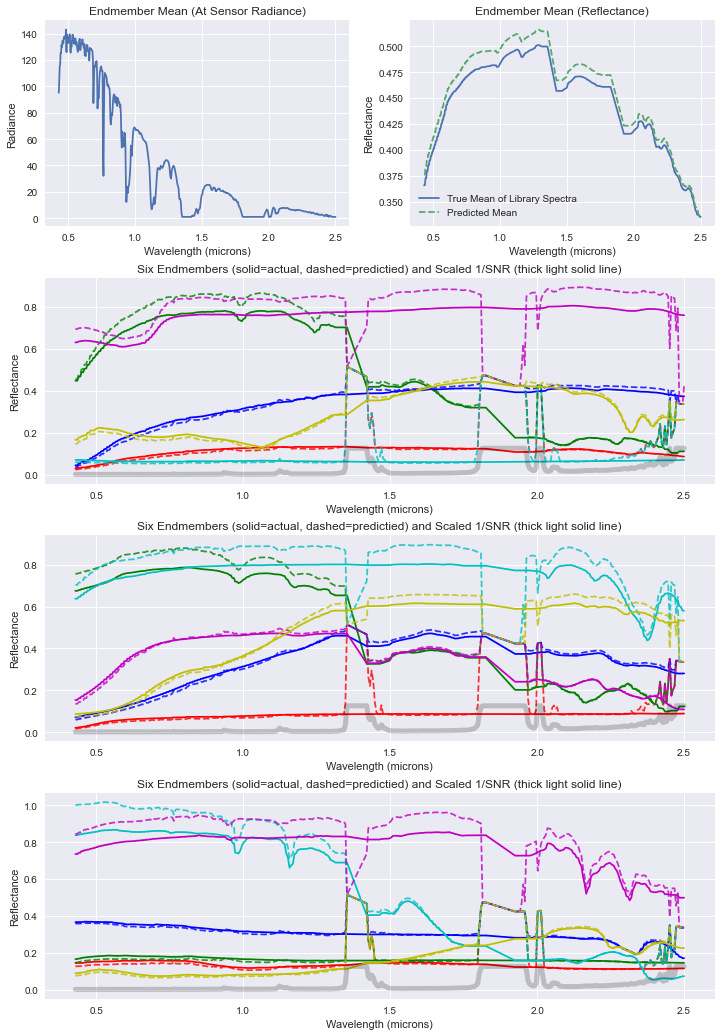

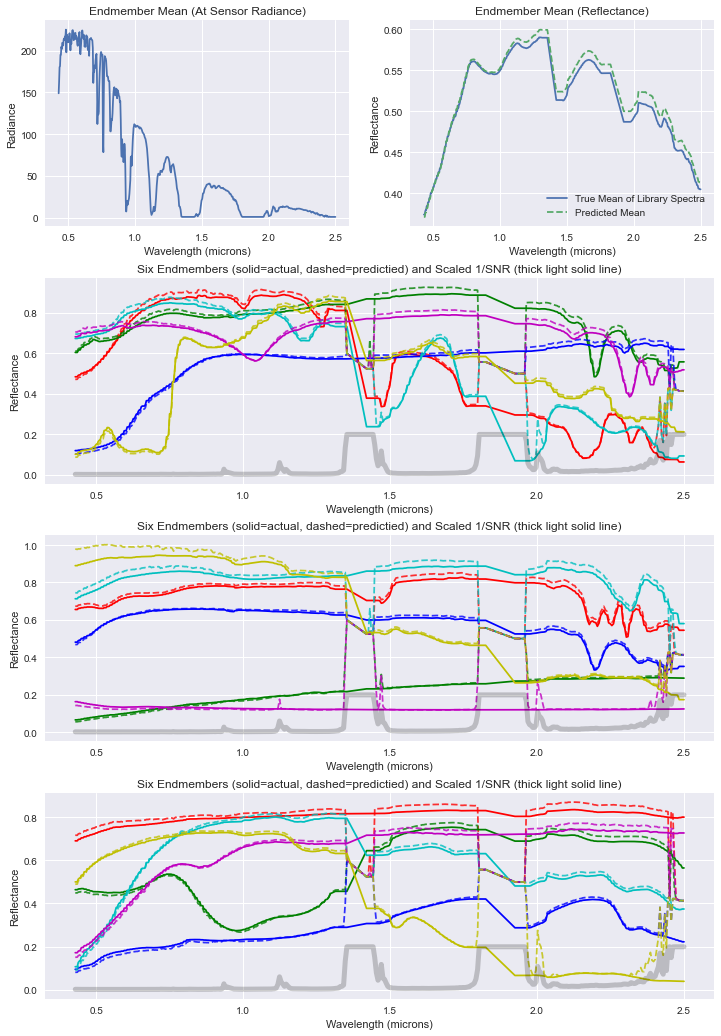

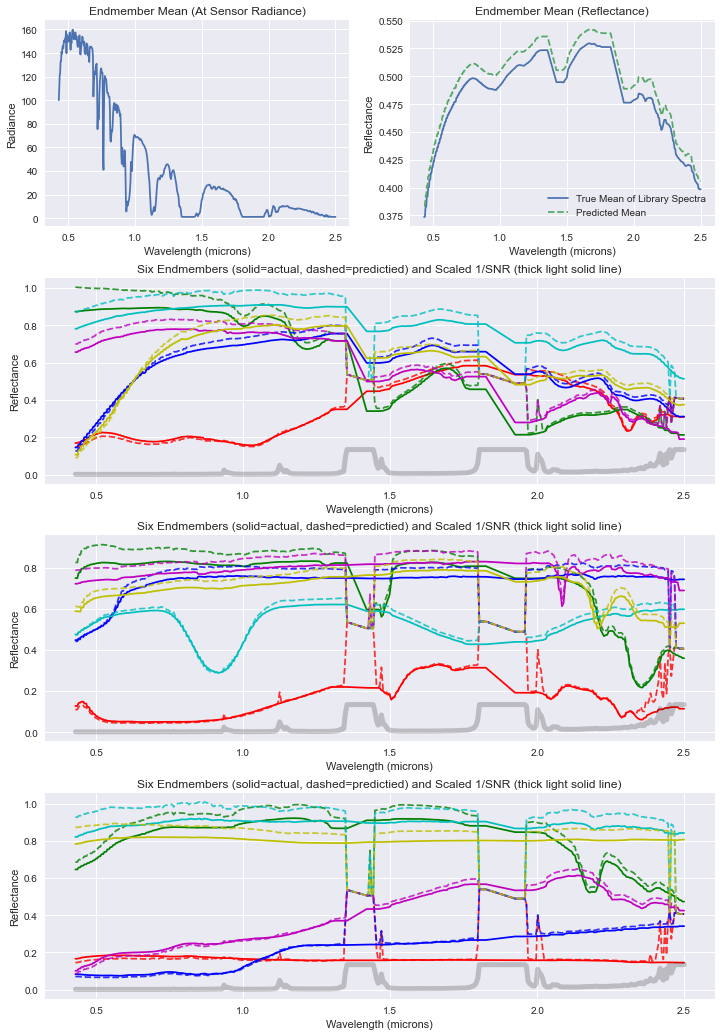

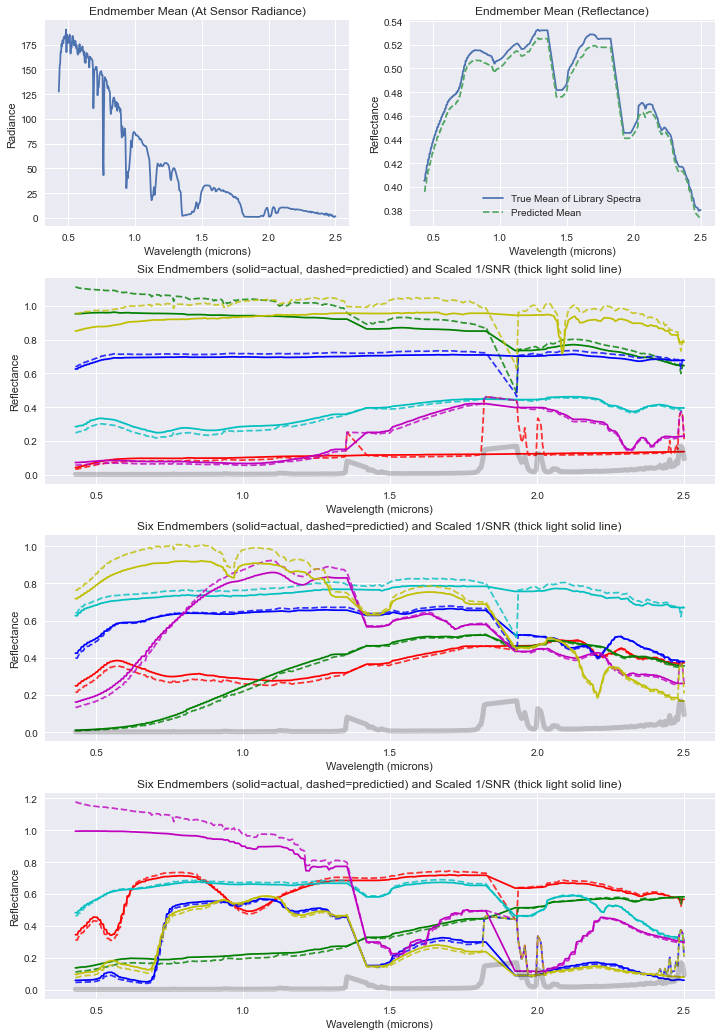

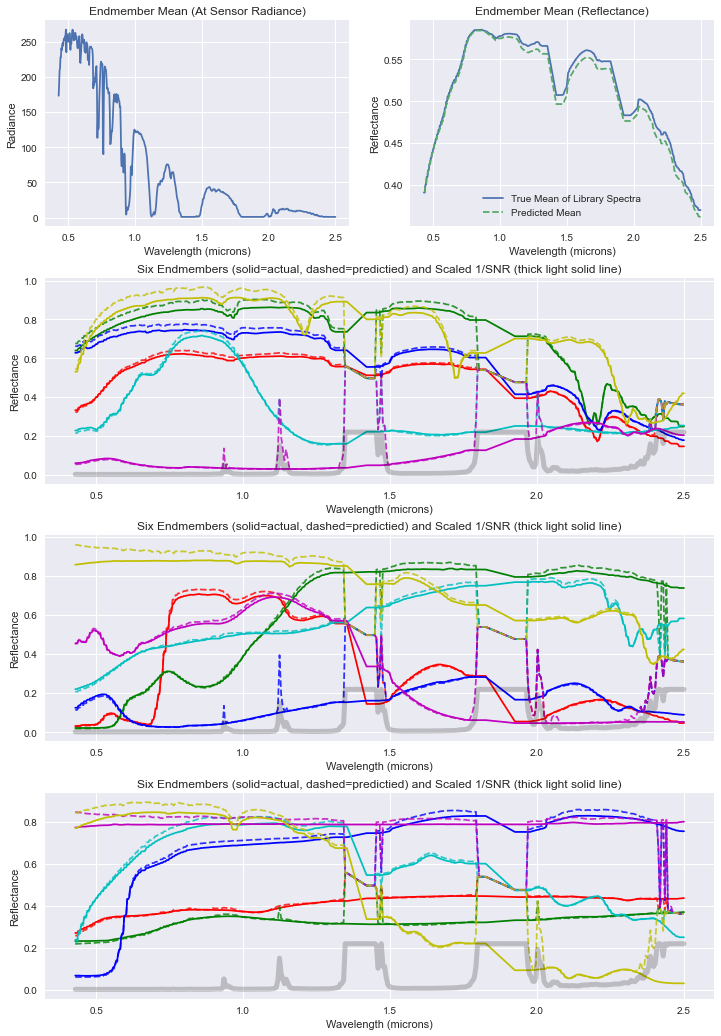

In [41]:
for i in range(5):
  idx = np.random.randint(0,nTestObs)
  Y_pred = pred(X_test[idx,:],m_a,m_b,Cba,CaaInv)
  gain = Y_pred/X_test[idx,:]
  SNRi = np.mean(X_test[idx,:])/(X_test[idx,:]*len(wl))
  #SNRi = SNRi/np.max(SNRi)

  fig = plt.figure(figsize=(12,18))
  grid = GridSpec(4, 2, figure=fig)
  plt.subplots_adjust(hspace=0.25)
  ax1 = fig.add_subplot(grid[0,0])
  ax1.plot(wl,X_test[idx,:])
  ax1.set_xlabel("Wavelength (microns)")
  ax1.set_ylabel("Radiance")
  ax1.set_title("Endmember Mean (At Sensor Radiance)")
  ax2 = fig.add_subplot(grid[0,1])
  ax2.plot(wl,Y_test[idx,:], label='True Mean of Library Spectra')
  ax2.plot(wl,Y_pred, '--', label='Predicted Mean')
  ax2.legend()
  ax2.set_xlabel("Wavelength (microns)")
  ax2.set_ylabel("Reflectance")
  ax2.set_title("Endmember Mean (Reflectance)")
  ax3 = fig.add_subplot(grid[1,0:2])
  ax3.plot(wl,Y_test_full[idx,2,:],'r')
  ax3.plot(wl,X_test_full[idx,2,:]*gain,'r--', alpha=0.8)
  ax3.plot(wl,Y_test_full[idx,3,:],'g')
  ax3.plot(wl,X_test_full[idx,3,:]*gain,'g--', alpha=0.8)
  ax3.plot(wl,Y_test_full[idx,4,:],'b')
  ax3.plot(wl,X_test_full[idx,4,:]*gain,'b--', alpha=0.8)
  ax3.plot(wl,Y_test_full[idx,5,:],'c')
  ax3.plot(wl,X_test_full[idx,5,:]*gain,'c--', alpha=0.8)
  ax3.plot(wl,Y_test_full[idx,6,:],'m')
  ax3.plot(wl,X_test_full[idx,6,:]*gain,'m--', alpha=0.8)
  ax3.plot(wl,Y_test_full[idx,7,:],'y')
  ax3.plot(wl,X_test_full[idx,7,:]*gain,'y--', alpha=0.8)
  ax3.plot(wl,SNRi, 'k', linewidth=5, alpha=0.2)
  ax3.set_title("Six Endmembers (solid=actual, dashed=predictied) and Scaled 1/SNR (thick light solid line)")
  ax3.set_xlabel("Wavelength (microns)")
  ax3.set_ylabel("Reflectance")
  ax4 = fig.add_subplot(grid[2,0:2])
  ax4.plot(wl,Y_test_full[idx,8,:],'r')
  ax4.plot(wl,X_test_full[idx,8,:]*gain,'r--', alpha=0.8)
  ax4.plot(wl,Y_test_full[idx,9,:],'g')
  ax4.plot(wl,X_test_full[idx,9,:]*gain,'g--', alpha=0.8)
  ax4.plot(wl,Y_test_full[idx,10,:],'b')
  ax4.plot(wl,X_test_full[idx,10,:]*gain,'b--', alpha=0.8)
  ax4.plot(wl,Y_test_full[idx,11,:],'c')
  ax4.plot(wl,X_test_full[idx,11,:]*gain,'c--', alpha=0.8)
  ax4.plot(wl,Y_test_full[idx,12,:],'m')
  ax4.plot(wl,X_test_full[idx,12,:]*gain,'m--', alpha=0.8)
  ax4.plot(wl,Y_test_full[idx,13,:],'y')
  ax4.plot(wl,X_test_full[idx,13,:]*gain,'y--', alpha=0.8);
  ax4.plot(wl,SNRi, 'k', linewidth=5, alpha=0.2)
  ax4.set_title("Six Endmembers (solid=actual, dashed=predictied) and Scaled 1/SNR (thick light solid line)")
  ax4.set_xlabel("Wavelength (microns)")
  ax4.set_ylabel("Reflectance")
  ax5 = fig.add_subplot(grid[3,0:2])
  ax5.plot(wl,Y_test_full[idx,14,:],'r')
  ax5.plot(wl,X_test_full[idx,14,:]*gain,'r--', alpha=0.8)
  ax5.plot(wl,Y_test_full[idx,15,:],'g')
  ax5.plot(wl,X_test_full[idx,15,:]*gain,'g--', alpha=0.8)
  ax5.plot(wl,Y_test_full[idx,16,:],'b')
  ax5.plot(wl,X_test_full[idx,16,:]*gain,'b--', alpha=0.8)
  ax5.plot(wl,Y_test_full[idx,17,:],'c')
  ax5.plot(wl,X_test_full[idx,17,:]*gain,'c--', alpha=0.8)
  ax5.plot(wl,Y_test_full[idx,18,:],'m')
  ax5.plot(wl,X_test_full[idx,18,:]*gain,'m--', alpha=0.8)
  ax5.plot(wl,Y_test_full[idx,19,:],'y')
  ax5.plot(wl,X_test_full[idx,19,:]*gain,'y--', alpha=0.8);
  ax5.plot(wl,SNRi, 'k', linewidth=5, alpha=0.2)
  ax5.set_title("Six Endmembers (solid=actual, dashed=predictied) and Scaled 1/SNR (thick light solid line)")
  ax5.set_xlabel("Wavelength (microns)")
  ax5.set_ylabel("Reflectance")
  plt.savefig('predictionResults_'+str(idx)+'.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

In [42]:
CC = Caa - np.matmul(np.matmul(Cab, np.linalg.pinv(Cbb)), Cba)
eVals, eVecs = np.linalg.eig(CC)

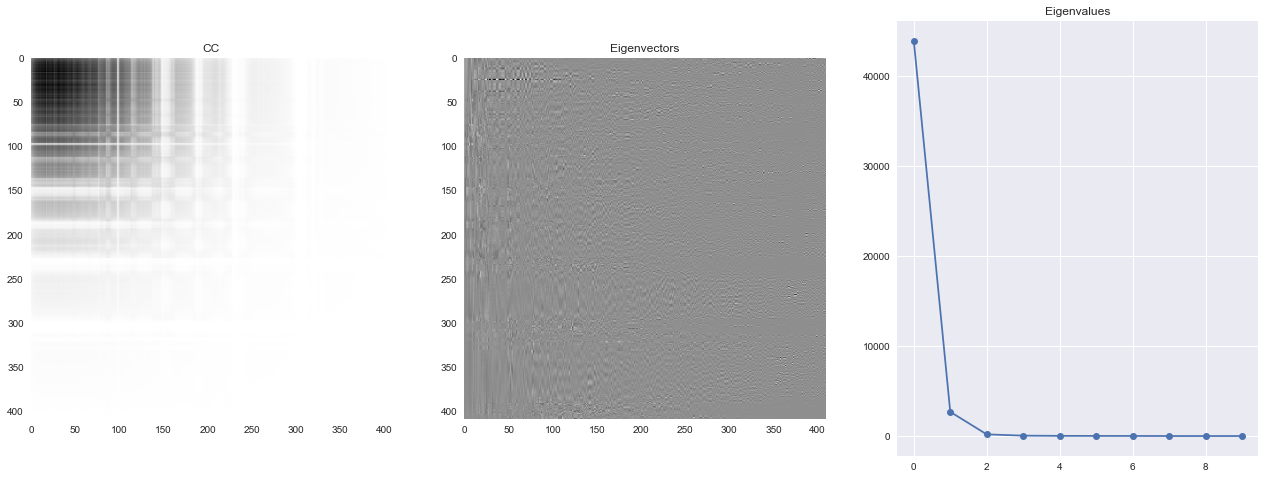

In [43]:
plt.figure(figsize=(22,8))
plt.subplot(131)
plt.imshow(CC)
plt.grid(None)
plt.title('CC')
plt.subplot(132)
plt.imshow(eVecs.real)
plt.grid(None)
plt.title('Eigenvectors')
plt.subplot(133)
plt.plot(eVals[0:10].real, 'o-')
plt.title('Eigenvalues');
plt.savefig('ConditionaCovariance.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

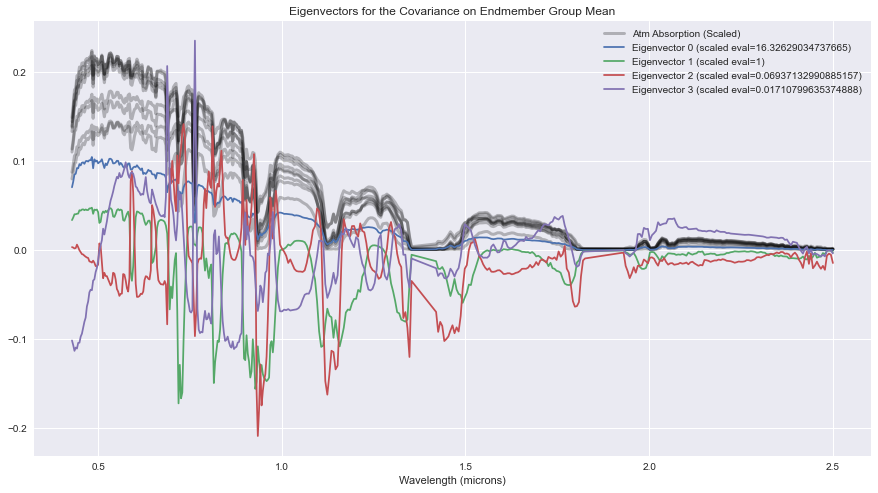

In [44]:
plt.figure(figsize=(15,8))
plt.plot(wl,0.001*X_test[0,:], 'k', linewidth = 3, alpha=0.25, label='Atm Absorption (Scaled)')
plt.plot(wl,0.001*X_test[1,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[2,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[3,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[4,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[5,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[6,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[7,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,0.001*X_test[8,:], 'k', linewidth = 3, alpha=0.25)
plt.plot(wl,(-1)*eVecs[:,0].real.flatten(), label='Eigenvector 0 (scaled eval='+str(eVals[0].real/eVals[1].real)+')')
plt.plot(wl,(-1)*eVecs[:,1].real.flatten(), label='Eigenvector 1 (scaled eval='+str(1)+')')
plt.plot(wl,eVecs[:,3].real.flatten(), label='Eigenvector 2 (scaled eval='+str(eVals[2].real/eVals[1].real)+')')
plt.plot(wl,eVecs[:,4].real.flatten(), label='Eigenvector 3 (scaled eval='+str(eVals[3].real/eVals[1].real)+')')
plt.legend()
plt.xlabel("Wavelength (microns)");
plt.title("Eigenvectors for the Covariance on Endmember Group Mean")
plt.savefig('covarianceEigenVectors.png', dpi=500, bbox_inches='tight', pad_inches=0.1);